In [1]:
import pandas as pd
import numpy as np
import bluebelt as blue
import bluebelt.analysis.ci as ci
import bluebelt.analysis.distribution as distribution


import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats as stats

ModuleNotFoundError: No module named 'bluebelt.analysis.ci'

In [2]:
#df = pd.read_pickle('data/data.pkl')

In [3]:
l = 100
#np.random.seed(27)
s = pd.Series(np.random.weibull(8,l), index=pd.date_range(start='1-1-2020', periods=l), name='main process')
#s = pd.Series(np.random.randint(100,200,l), index=pd.date_range(start='1-1-2020', periods=l), name='main process')

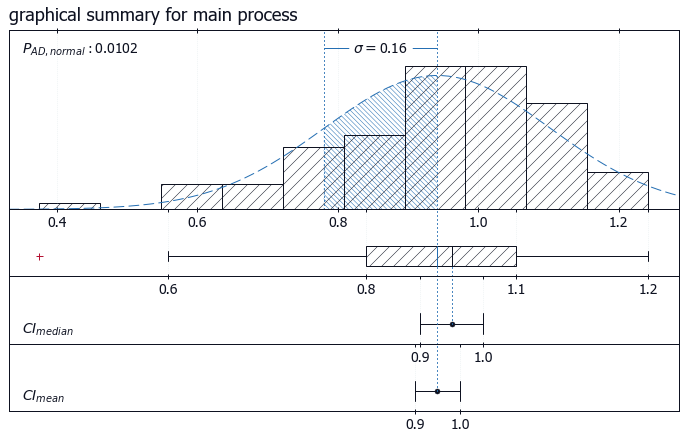

In [4]:
s.blue.ppa.summary().plot(figsize=(12,7))

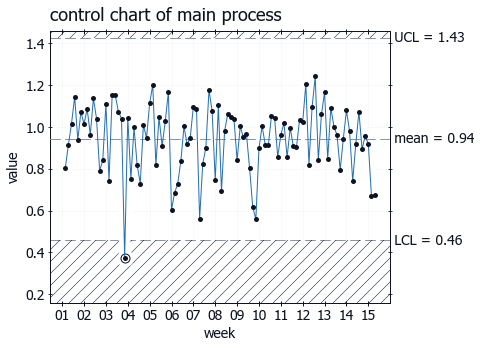

In [5]:
s.blue.ppa.control_chart().plot(figsize=(7,5))

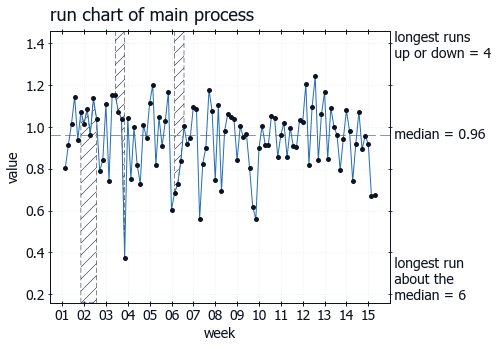

In [6]:
s.blue.ppa.run_chart().plot(figsize=(7,5))

In [7]:
blue.analysis.distribution.anderson_darling(s)

TestResults(name='Distribution Test (norm)', test='Anderson-Darling', statistic=0.82, pvalue=0.0303, passed=False)

In [8]:
blue.analysis.ci.confidence_interval_mean(s)

(0.9074863167257458, 0.9664282153203844)

In [43]:
class Summary():
        
    def __init__(self, series, **kwargs):
        
        self.series = series
        self.calculate()
        
    def __str__(self):
        str_mean="mean:"
        str_ci_mean="CI mean:"
        str_std="standard deviation:"
        str_min="minimum"
        str_q1="1st quantile:"
        str_median="median:"
        str_q3="3rd quantile:"
        str_max="maximum"
        str_ci_median="CI median:"
        str_ad_test="Anderson-Darling test"
        
        

        fill = 32
        return (f'{str_mean:{fill}}{self.mean:1.2f}\n' +
                f'{str_ci_mean:{fill}}{self.ci_mean[0]:1.2f}-{self.ci_mean[1]:1.2f}\n' +
                f'{str_std:{fill}}{self.std:1.2f}\n' +
                f'{str_min:{fill}}{self.min:1.2f}\n' +
                f'{str_q1:{fill}}{self.q1:1.2f}\n' +
                f'{str_median:{fill}}{self.median}\n' +
                f'{str_q3:{fill}}{self.q3:1.2f}\n' +
                f'{str_max:{fill}}{self.max:1.2f}\n' +
                f'{str_ci_median:{fill}}{self.ci_median[0]:1.2f}-{self.ci_median[1]:1.2f}\n' +
                f'{str_ad_test:{fill}}A={self.ad_test.statistic:1.2f}, p-value={self.ad_test.pvalue:1.2f}')
                

    def __repr__(self):
        return (f'{self.__class__.__name__}(mean={self.mean:1.1f}, std={self.std:1.1f}, min={self.min:1.1f}, q1={self.q1:1.1f}, median={self.median:1.1f}, q3={self.q3:1.1f}, max={self.max:1.1f})')
    
    def calculate(self):
        self.mean = self.series.mean()
        self.ci_mean = ci.ci_mean(self.series)
        self.std = self.series.std()
        self.min = self.series.min()
        self.q1 = self.series.quantile(q=0.25)
        self.median = self.series.median()
        self.q3 = self.series.quantile(q=0.75)
        self.max = self.series.max()
        self.ci_median = ci.ci_median(self.series)
        self.ad_test = distribution.anderson_darling(self.series)
        
        
    def get_boxplot_quantiles(self, whis=1.5):
        # get the matplotlib boxplot quantiles
        # sort of direct copy from the matplotlib library

        q1, median, q3 = np.percentile(self.series, [25, 50, 75])

        if np.isscalar(whis):
            iqr = q3 - q1
            loval = q1 - (whis * iqr)
            hival = q3 + (whis * iqr)

            self.series[self.series >= loval].min()

            wiskhi = self.series[self.series <= hival]
            if len(wiskhi) == 0 or np.max(wiskhi) < q3:
                high = q3
            else:
                high = np.max(wiskhi)

            # get low extreme
            wisklo = self.series[self.series >= loval]
            if len(wisklo) == 0 or np.min(wisklo) > q1:
                low = q1
            else:
                low = np.min(wisklo)
        else:
            low, high = np.percentile(series, sorted(whis))

        return (low, q1, q3, high)

    def get_boxplot_outliers(self, whis=1.5):
        low, q1, q3, high = get_boxplot_quantiles(self.series)

        return self.series[self.series < low].append(self.series[self.series > high]).values
    
    def plot(self, **kwargs):
    
        # prepare figure
        fig = plt.figure(constrained_layout=False, **kwargs)
        gridspec = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[8,3,3,3], wspace=0, hspace=0)
        ax1 = fig.add_subplot(gridspec[0, 0], zorder=50)
        ax2 = fig.add_subplot(gridspec[1, 0], zorder=40)
        ax3 = fig.add_subplot(gridspec[2, 0], zorder=30)
        ax4 = fig.add_subplot(gridspec[3, 0], zorder=20)

        #######################################################
        # 1. histogram
        #######################################################

        N, bins, patches = ax1.hist(self.series, fill=False, linewidth=1, density=True)#, hatch='//')

        hatches = ['////', '//////']
        for i, patch in enumerate(patches):
            patch.set(hatch=hatches[i%len(hatches)])

        # fit a normal distribution to the data
        norm_mu, norm_std = stats.norm.fit(self.series)

        # get current limits
        xlims = ax1.get_xlim()
        ylims = ax1.get_ylim()


        # plot pdf
        pdf_x = np.linspace(xlims[0], xlims[1], 100)
        pdf_y = stats.norm.pdf(pdf_x, norm_mu, norm_std)
        ax1.plot(pdf_x, pdf_y, linewidth=1, ls='dashed', color=blue.helpers.defaults.blue)

        # plot 1*std pdf
        ax1.fill_between(np.linspace(self.mean-self.std, self.mean, 100), stats.norm.pdf(np.linspace(self.mean-self.std, self.mean, 100), norm_mu, norm_std), 0, linewidth=0, color=None, hatch='\\\\', ec='blue')

        # mean line, std line
        ax1.axvline(x=self.mean, ymin=0, ymax=1, color='blue', ls='dotted')
        ax1.axvline(x=self.mean-self.std, ymin=0, ymax=1, color='blue', ls='dotted')
        ax1.axvline(x=self.mean+self.std, ymin=0, ymax=1, color='blue', ls='dotted')

        # std text and lines
        ax1.text(self.mean-self.std*0.5, ylims[1]*0.9, r'$\sigma = $'+f'{self.std:1.2f}', va='center', ha='center', backgroundcolor='white')
        ax1.plot((self.mean-self.std, self.mean), (ylims[1]*0.9, ylims[1]*0.9), color='black', lw=1)
        ax1.plot((self.mean-self.std, self.mean-self.std), (ylims[1]*0.95, ylims[1]*0.85), color='black')
        ax1.plot((self.mean, self.mean), (ylims[1]*0.95, ylims[1]*0.85), color='black')

        # reset limits
        ax1.set_xlim(xlims)
        ax1.set_ylim(ylims)

        #######################################################
        # 1. box plot
        #######################################################

        boxplot = ax2.boxplot(self.series, vert=False, widths=0.3)

        for box in boxplot['boxes']:
            box.set(hatch='//')

        ax2.set_xlim(xlims)
        ax2.set_ylim(0.7,1.7)


        #######################################################
        # CI for the median
        #######################################################

        ax3.plot([self.ci_median[0], self.ci_median[1]], [1,1], color='black')
        ax3.axvline(x=self.ci_median[0], ymin=0.15, ymax=0.45, color='black')
        ax3.axvline(x=self.ci_median[1], ymin=0.15, ymax=0.45, color='black')
        ax3.scatter([self.median],[1], color='black')
        ax3.set_xlim(xlims)
        ax3.set_ylim(0.7,1.7)

        ax2.axvline(self.median, ymin=0, ymax=0.3, color='black', ls='dotted')
        ax3.axvline(self.median, ymin=0.3, ymax=1.7, color='black', ls='dotted')

        #######################################################
        # CI for the mean
        #######################################################

        ax4.plot([self.ci_mean[0], self.ci_mean[1]], [1,1], color='black')
        ax4.axvline(x=self.ci_mean[0], ymin=0.15, ymax=0.45, color='black')
        ax4.axvline(x=self.ci_mean[1], ymin=0.15, ymax=0.45, color='black')
        ax4.scatter([self.mean],[1], color='black')
        ax4.set_xlim(xlims)
        ax4.set_ylim(0.7,1.7)

        ax2.axvline(self.mean, ymin=0, ymax=2, color='red', ls='dotted')
        ax3.axvline(self.mean, ymin=0, ymax=1.7, color='red', ls='dotted')
        ax4.axvline(self.mean, ymin=0.3, ymax=1.7, color='red', ls='dotted')


        #ax1.set_yticks([])
        ax2.set_yticks([])
        ax3.set_yticks([])
        ax4.set_yticks([])

        ax2_xticks = get_boxplot_quantiles(self.series)
        #ax2_xticks = [s.quantile(q=0), s.quantile(q=0.25), s.median(), s.quantile(q=0.75), s.max()]

        ax3_xticks = [self.ci_median[0], self.median, self.ci_median[1]]
        ax4_xticks = [self.ci_mean[0], self.mean, self.ci_mean[1]]

        ax2.set_xticks(ax2_xticks)
        ax3.set_xticks(ax3_xticks)
        ax4.set_xticks(ax4_xticks)

        ax1.set_title(f'graphical summary for {self.series.name}', loc='left')

In [44]:
test = Summary(s)

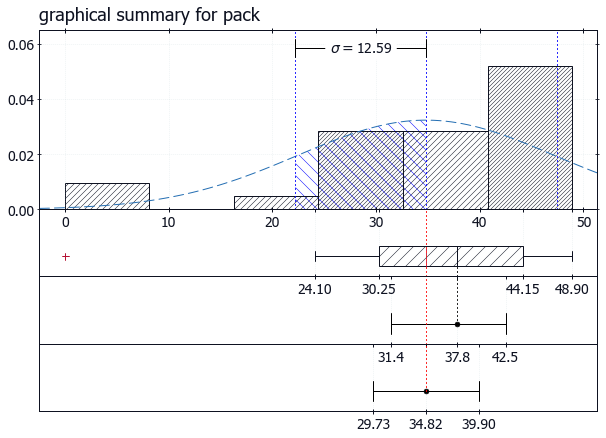

In [45]:
test.plot()

In [8]:
def anderson_darling(s):
    AD, critical_values, significance_level = stats.anderson(s, dist='norm')
    AD_adjusted = AD*(1 + (.75/50) + 2.25/(50**2))
    if AD_adjusted >= .6:
        p = math.exp(1.2937 - 5.709*AD_adjusted - .0186*(AD_adjusted**2))
    elif AD_adjusted >=.34:
        p = math.exp(.9177 - 4.279*AD_adjusted - 1.38*(AD_adjusted**2))
    elif AD_adjusted >.2:
        p = 1 - math.exp(-8.318 + 42.796*AD_adjusted - 59.938*(AD_adjusted**2))
    else:
        p = 1 - math.exp(-13.436 + 101.14*AD_adjusted - 223.73*(AD_adjusted**2))
    
    return (AD, AD_adjusted, p)

In [104]:
def plot(series, **kwargs):
    
    # prepare data
    mean = series.mean()
    std = series.std()

    # prepare figure
    fig = plt.figure(constrained_layout=False, **kwargs)
    gridspec = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[8,3,3,3], wspace=0, hspace=0)
    ax1 = fig.add_subplot(gridspec[0, 0], zorder=50)
    ax2 = fig.add_subplot(gridspec[1, 0], zorder=40)
    ax3 = fig.add_subplot(gridspec[2, 0], zorder=30)
    ax4 = fig.add_subplot(gridspec[3, 0], zorder=20)

    #######################################################
    # 1. histogram
    #######################################################

    N, bins, patches = ax1.hist(series, fill=False, linewidth=1, density=True)#, hatch='//')

    hatches = ['////', '//////']
    for i, patch in enumerate(patches):
        patch.set(hatch=hatches[i%len(hatches)])

    # fit a normal distribution to the data
    norm_mu, norm_std = stats.norm.fit(series)

    # get current limits
    xlims = ax1.get_xlim()
    ylims = ax1.get_ylim()
    
    
    # plot pdf
    pdf_x = np.linspace(xlims[0], xlims[1], 100)
    pdf_y = stats.norm.pdf(pdf_x, norm_mu, norm_std)
    ax1.plot(pdf_x, pdf_y, linewidth=1, ls='dashed', color=blue.helpers.defaults.blue)
    
    # plot 1*std pdf
    ax1.fill_between(np.linspace(mean-std, mean, 100), stats.norm.pdf(np.linspace(mean-std, mean, 100), norm_mu, norm_std), 0, linewidth=0, color=None, hatch='\\\\', ec='blue')

    # mean line, std line
    ax1.axvline(x=mean, ymin=0, ymax=1, color='blue', ls='dotted')
    ax1.axvline(x=mean-std, ymin=0, ymax=1, color='blue', ls='dotted')
    ax1.axvline(x=mean+std, ymin=0, ymax=1, color='blue', ls='dotted')
    
    # std text and lines
    ax1.text(mean - std*0.5, ylims[1]*0.9, r'$\sigma = $'+f'{std:1.2f}', va='center', ha='center', backgroundcolor='white')
    ax1.plot((mean-std, mean), (ylims[1]*0.9, ylims[1]*0.9), color='black', lw=1)
    ax1.plot((mean-std, mean-std), (ylims[1]*0.95, ylims[1]*0.85), color='black')
    ax1.plot((mean, mean), (ylims[1]*0.95, ylims[1]*0.85), color='black')
    
    # reset limits
    ax1.set_xlim(xlims)
    ax1.set_ylim(ylims)

    #######################################################
    # 1. box plot
    #######################################################

    boxplot = ax2.boxplot(series, vert=False, widths=0.3)

    for box in boxplot['boxes']:
        box.set(hatch='//')

    ax2.set_xlim(xlims)
    ax2.set_ylim(0.7,1.7)


    #######################################################
    # CI for the median
    #######################################################

    ci_median = confidence_interval_median(series)
    ax3.plot([ci_median[0], ci_median[1]], [1,1], color='black')
    ax3.axvline(x=ci_median[0], ymin=0.15, ymax=0.45, color='black')
    ax3.axvline(x=ci_median[1], ymin=0.15, ymax=0.45, color='black')
    ax3.scatter([series.median()],[1], color='black')
    ax3.set_xlim(xlims)
    ax3.set_ylim(0.7,1.7)

    ax2.axvline(series.median(), ymin=0, ymax=0.3, color='black', ls='dotted')
    ax3.axvline(series.median(), ymin=0.3, ymax=1.7, color='black', ls='dotted')

    #######################################################
    # CI for the mean
    #######################################################
    
    ci_mean = confidence_interval_mean(series)
    ax4.plot([ci_mean[0], ci_mean[1]], [1,1], color='black')
    ax4.axvline(x=ci_mean[0], ymin=0.15, ymax=0.45, color='black')
    ax4.axvline(x=ci_mean[1], ymin=0.15, ymax=0.45, color='black')
    ax4.scatter([s.mean()],[1], color='black')
    ax4.set_xlim(xlims)
    ax4.set_ylim(0.7,1.7)

    ax2.axvline(series.mean(), ymin=0, ymax=2, color='red', ls='dotted')
    ax3.axvline(series.mean(), ymin=0, ymax=1.7, color='red', ls='dotted')
    ax4.axvline(series.mean(), ymin=0.3, ymax=1.7, color='red', ls='dotted')


    #ax1.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax4.set_yticks([])

    ax2_xticks = get_boxplot_quantiles(series)
    #ax2_xticks = [s.quantile(q=0), s.quantile(q=0.25), s.median(), s.quantile(q=0.75), s.max()]

    ax3_xticks = [ci_median[0], series.median(), ci_median[1]]
    ax4_xticks = [ci_mean[0], series.mean(), ci_mean[1]]

    ax2.set_xticks(ax2_xticks)
    ax3.set_xticks(ax3_xticks)
    ax4.set_xticks(ax4_xticks)

    ax1.set_title(f'graphical summary for {s.name}', loc='left')


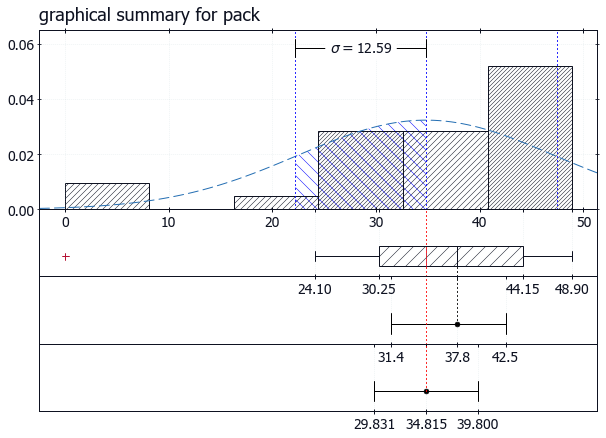

In [105]:
plot(s)

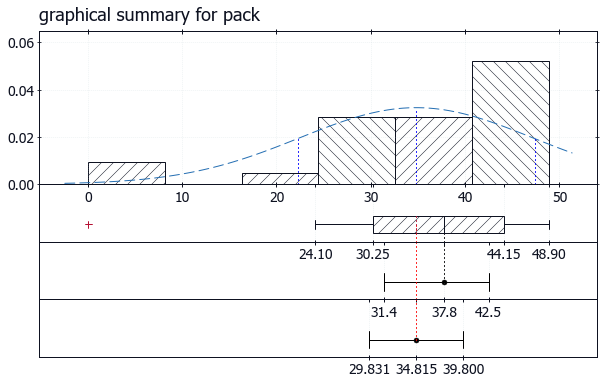

In [205]:

mean = s.mean()
std = s.std()


# prepare figure
fig = plt.figure(constrained_layout=False, figsize=(10,6))
gridspec = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[8,3,3,3], wspace=0, hspace=0)
ax1 = fig.add_subplot(gridspec[0, 0], zorder=50)
ax2 = fig.add_subplot(gridspec[1, 0], zorder=40)
ax3 = fig.add_subplot(gridspec[2, 0], zorder=30)
ax4 = fig.add_subplot(gridspec[3, 0], zorder=20)

# histogram

N, bins, patches = ax1.hist(s, fill=False, linewidth=1, density=True)

hatches = ['//', '\\\\']
for i, patch in enumerate(patches):
    patch.set(hatch=hatches[i%len(hatches)])

# fit a normal distribution to the data
norm_mu, norm_std = stats.norm.fit(s)

# plot the PDF
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, norm_mu, norm_std)
ax1.plot(x, p, linewidth=1, ls='dashed', color=blue.helpers.defaults.blue)
ax1.set_title(f'graphical summary for {s.name}', loc='left')

# mean line, std lines
ax1.axvline(x=mean, ymin=0, ymax=stats.norm.pdf(mean, norm_mu, norm_std)/(ax1.get_ylim()[1]-ax1.get_ylim()[0]), color='blue', ls='dotted')
ax1.axvline(x=mean-std, ymin=0, ymax=stats.norm.pdf(mean-std, norm_mu, norm_std)/(ax1.get_ylim()[1]-ax1.get_ylim()[0]), color='blue', ls='dotted')
ax1.axvline(x=mean+std, ymin=0, ymax=stats.norm.pdf(mean-std, norm_mu, norm_std)/(ax1.get_ylim()[1]-ax1.get_ylim()[0]), color='blue', ls='dotted')

# get x_lims
x_lims = ax1.get_xlim()

# box plot

boxplot = ax2.boxplot(s, vert=False, widths=0.3)

for box in boxplot['boxes']:
    box.set(hatch='//')

ax2.set_xlim(x_lims)
ax2.set_ylim(0.7,1.7)

    
# CI for the median
ci_median = confidence_interval_median(s)
ax3.plot([ci_median[0], ci_median[1]], [1,1], color='black')
ax3.axvline(x=ci_median[0], ymin=0.15, ymax=0.45, color='black')
ax3.axvline(x=ci_median[1], ymin=0.15, ymax=0.45, color='black')
ax3.scatter([s.median()],[1], color='black')
ax3.set_xlim(x_lims)
ax3.set_ylim(0.7,1.7)

ax2.axvline(s.median(), ymin=0, ymax=0.3, color='black', ls='dotted')
ax3.axvline(s.median(), ymin=0.3, ymax=1.7, color='black', ls='dotted')


# CI for the mean
ci_mean = confidence_interval_mean(s)
ax4.plot([ci_mean[0], ci_mean[1]], [1,1], color='black')
ax4.axvline(x=ci_mean[0], ymin=0.15, ymax=0.45, color='black')
ax4.axvline(x=ci_mean[1], ymin=0.15, ymax=0.45, color='black')
ax4.scatter([s.mean()],[1], color='black')
ax4.set_xlim(x_lims)
ax4.set_ylim(0.7,1.7)

ax2.axvline(s.mean(), ymin=0, ymax=0.3, color='red', ls='dotted')
ax3.axvline(s.mean(), ymin=0, ymax=1.7, color='red', ls='dotted')
ax4.axvline(s.mean(), ymin=0.3, ymax=1.7, color='red', ls='dotted')


#ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

ax2_xticks = np.unique(np.concatenate((#boxplot['medians'][0].get_xdata(),
                                       boxplot['whiskers'][0].get_xdata(),
                                       boxplot['whiskers'][1].get_xdata(),
                                       boxplot['caps'][0].get_xdata(),
                                       boxplot['caps'][1].get_xdata())))
#ax2_xticks = [s.quantile(q=0), s.quantile(q=0.25), s.median(), s.quantile(q=0.75), s.max()]

ax3_xticks = [ci_median[0], s.median(), ci_median[1]]
ax4_xticks = [ci_mean[0], s.mean(), ci_mean[1]]

ax2.set_xticks(ax2_xticks)
ax3.set_xticks(ax3_xticks)
ax4.set_xticks(ax4_xticks)


In [137]:
tuple(sorted((4,2,5,2)))

(2, 2, 4, 5)

In [169]:
get_boxplot_quantiles(s, 1.5)

NameError: name 'series' is not defined

In [96]:
np.unique(np.concatenate((boxplot['medians'][0].get_xdata(),
                boxplot['whiskers'][0].get_xdata(),
                boxplot['whiskers'][1].get_xdata(),
                boxplot['caps'][0].get_xdata(),
                boxplot['caps'][1].get_xdata())))

array([23.6  , 31.1  , 40.1  , 44.175, 49.4  ])

In [331]:
array2=np.unique([x for x, y in boxplot['boxes'][0].get_path().vertices[:-1]])

In [332]:
np.setdiff1d(array2, array1)

array([36.07417701, 44.12582299])

In [333]:
boxplot['boxes'][0].get_path()

Path(array([[31.1       ,  0.85      ],
       [31.1       ,  1.15      ],
       [36.07417701,  1.15      ],
       [40.1       ,  1.075     ],
       [44.12582299,  1.15      ],
       [44.175     ,  1.15      ],
       [44.175     ,  0.85      ],
       [44.12582299,  0.85      ],
       [40.1       ,  0.925     ],
       [36.07417701,  0.85      ],
       [31.1       ,  0.85      ],
       [ 0.        ,  0.        ]]), array([ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 79], dtype=uint8))

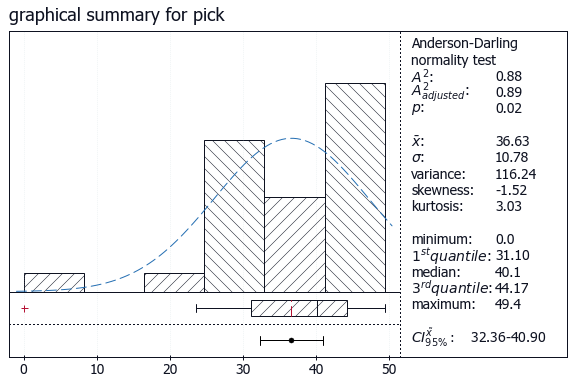

In [248]:
fig = plt.figure(constrained_layout=False, figsize=(10,6))
gridspec = fig.add_gridspec(nrows=3, ncols=2, width_ratios=[7,3], height_ratios=[8,1,1], wspace=0, hspace=0)
ax1 = fig.add_subplot(gridspec[0, 0])
ax2 = fig.add_subplot(gridspec[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gridspec[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gridspec[:, 1])

# histogram

N, bins, patches = ax1.hist(s, fill=False, linewidth=1, density=True)

hatches = ['//', '\\\\']
for i, patch in enumerate(patches):
    patch.set(hatch=hatches[i%len(hatches)])

# fit a normal distribution to the data
mu, std = stats.norm.fit(s)

# plot the PDF
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax1.plot(x, p, linewidth=1, ls='dashed', color=blue.helpers.defaults.blue)
ax1.set_title(f'graphical summary for {s.name}', loc='left')


# box plot

boxplot = ax2.boxplot(s, vert=False, widths=0.5)

for box in boxplot['boxes']:
    box.set(hatch='//')

# CI for the mean
ci = confidence_interval_mean(s)
ax3.plot([ci[0], ci[1]], [1,1], color='black')
ax3.axvline(x=ci[0], ymin=0.35, ymax=0.65, color='black')
ax3.axvline(x=ci[1], ymin=0.35, ymax=0.65, color='black')
ax3.scatter([s.mean()],[1], color='black')



plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# change spines between plots
#ax2.spines['top'].set_linestyle("dotted")
ax2.spines['bottom'].set_visible(False)
#ax3.spines['top'].set_visible(False)
ax3.spines['top'].set_linestyle("dotted")
#ax3.spines['top'].set_color("grey")

# remove ticks between plots
ax1.xaxis.set_ticks_position('none')
ax2.xaxis.set_ticks_position('none')
ax3.xaxis.set_ticks_position('bottom')

# remove grid in last plot
ax4.grid(False)

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax4.set_xticks([])

ax1.spines['right'].set_visible(False)
ax4.spines['left'].set_linestyle("dotted")

ad_results = anderson_darling(s)

loc = [[0.07, val/100] for val in range(96, 5, -5)]
text = [
    f'Anderson-Darling', '',
    f'normality test', '',
    r'$A^2$:', f'{ad_results[0]:1.2f}',
    r'$A^2_{adjusted}$:', f'{ad_results[1]:1.2f}',
    r'$p$:', f'{ad_results[2]:1.2f}',
    '','',
    r'$\bar{x}$:', f'{s.mean():1.2f}',
    r'$\sigma$:', f'{s.std():1.2f}',
    f'variance:', f'{s.var():1.2f}',
    f'skewness:', f'{stats.skew(s):1.2f}',
    f'kurtosis:', f'{stats.kurtosis(s):1.2f}',
    '','',
    'minimum:', f'{s.min()}',
    r'$1^{st} quantile$:', f'{s.quantile(q=0.25):1.2f}',
    'median:', f'{s.median()}',
    r'$3^{rd} quantile$:', f'{s.quantile(q=0.75):1.2f}',
    'maximum:', f'{s.max()}',
    '','',
    r'$CI_{95\%}^{\tilde{x}}:$'+f'   {ci[0]:1.2f}-{ci[1]:1.2f}','',
    
    
    
    
]
for i, location in enumerate(loc):
    ax4.text(loc[i][0], loc[i][1], text[2*i], va='center', ha='left')
    ax4.text(loc[i][0]+0.5, loc[i][1], text[2*i+1], va='center', ha='left')



plt.show()

In [214]:
loc

[[0.07, 0.98],
 [0.07, 0.93],
 [0.07, 0.88],
 [0.07, 0.83],
 [0.07, 0.78],
 [0.07, 0.73],
 [0.07, 0.68],
 [0.07, 0.63],
 [0.07, 0.58],
 [0.07, 0.53],
 [0.07, 0.48],
 [0.07, 0.43]]

In [187]:
loc = [[val/100, 0.07] for val in range(98, 0, -5)]
text = [
    f'Anderson-Darling', '',
    f'normality test', '',
    r'$A^2$:', f'{ad_results[0]:1.2f}',
    r'$A^2_{adjusted}$:', f'{ad_results[1]:1.2f}'
    r'$p$:', f'{ad_results[2]:1.2f}'
    r'$\bar{x}$:', f'{s.mean():1.2f}',
    r'$\sigma$:', f'{s.std():1.2f}'
    
]
for i, location in enumerate(loc):
    print(loc[i][0], loc[i][1], text[2*i])
    print(loc[i][0], loc[i][1]+0.5, text[2*i+1])



0.98 0.07 Anderson-Darling
0.98 0.5700000000000001 
0.93 0.07 normality test
0.93 0.5700000000000001 
0.88 0.07 $A^2$:
0.88 0.5700000000000001 0.88
0.83 0.07 $A^2_{adjusted}$:
0.83 0.5700000000000001 0.89$p$:
0.78 0.07 0.02$\bar{x}$:
0.78 0.5700000000000001 36.63
0.73 0.07 $\sigma$:
0.73 0.5700000000000001 10.78


IndexError: list index out of range

In [190]:
loc

[[0.07, 0.98],
 [0.07, 0.93],
 [0.07, 0.88],
 [0.07, 0.83],
 [0.07, 0.78],
 [0.07, 0.73],
 [0.07, 0.68],
 [0.07, 0.63],
 [0.07, 0.58],
 [0.07, 0.53],
 [0.07, 0.48],
 [0.07, 0.43],
 [0.07, 0.38],
 [0.07, 0.33],
 [0.07, 0.28],
 [0.07, 0.23],
 [0.07, 0.18],
 [0.07, 0.13],
 [0.07, 0.08],
 [0.07, 0.03]]

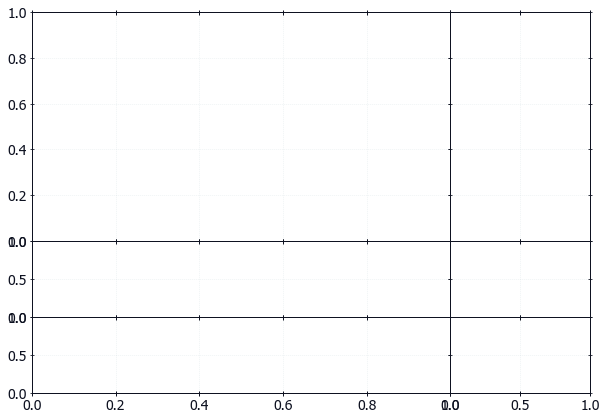

In [24]:
gridspec_kw = dict(width_ratios=[3,1], height_ratios=[3,1,1])
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,7), gridspec_kw=gridspec_kw, sharex='col', sharey='row')

#axes[1, 0] = plt.subplot(gs[1], sharex = axes[0, 0])

plt.subplots_adjust(wspace=0, hspace=0)

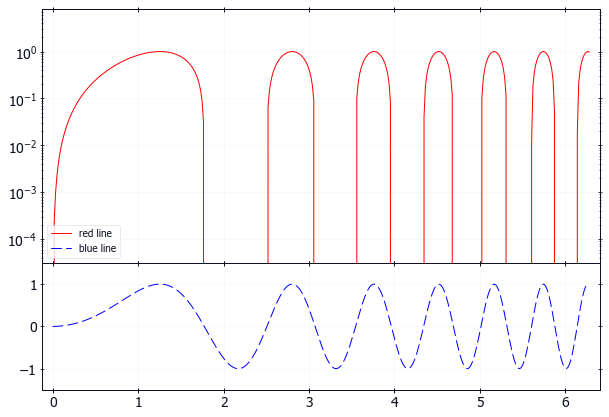

In [11]:
# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig = plt.figure()
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
ax0.set_yscale("log")
line0, = ax0.plot(x, y, color='r')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
line1, = ax1.plot(x, y, color='b', linestyle='--')
plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# put lened on first subplot
ax0.legend((line0, line1), ('red line', 'blue line'), loc='lower left')

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

In [ ]:
fig9 = plt.figure(constrained_layout=False)
gs1 = fig9.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48,
                        wspace=0.05)
f9_ax1 = fig9.add_subplot(gs1[:-1, :])
f9_ax2 = fig9.add_subplot(gs1[-1, :-1])
f9_ax3 = fig9.add_subplot(gs1[-1, -1])

gs2 = fig9.add_gridspec(nrows=3, ncols=3, left=0.55, right=0.98,
                        hspace=0.05)
f9_ax4 = fig9.add_subplot(gs2[:, :-1])
f9_ax5 = fig9.add_subplot(gs2[:-1, -1])
f9_ax6 = fig9.add_subplot(gs2[-1, -1])

In [10]:
x = {
    'test': {
        'test': 1}
}

In [14]:
x.get('test').get('test')

1